# Final Assignment
## Murat Tirkeshov

In [5]:
import os
import datetime
import pandas as pd
import numpy as np
import sys
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import sklearn.metrics as metrics
from sklearn.metrics import brier_score_loss, roc_curve, auc, confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display
from sklearn.metrics import roc_auc_score
prng = np.random.RandomState(20250406)

# Data

In [6]:
base_dir = os.getcwd()
data_path = os.path.join(base_dir, '../../data/cleaned/train.csv')
test_path = os.path.join(base_dir, '../../data/cleaned/test.csv')
data = pd.read_csv(data_path)
test = pd.read_csv(test_path)

In [7]:
to_filter=data.isna().sum()
to_filter[to_filter>0].sort_values(ascending = False)

Series([], dtype: int64)

In [8]:
data['is_popular'].mean()

0.12164934584468436

The dataset contains no missing values, which allowed for direct use in modeling without imputation or cleaning. The target variable, is_popular, is binary and represents whether an article is among the most widely shared on social media. The mean value of is_popular is approximately 0.1216, indicating that around 12.16% of the articles in the dataset are considered popular. This reflects a degree of class imbalance that should be taken into account during model evaluation and selection.

## Data Visualization

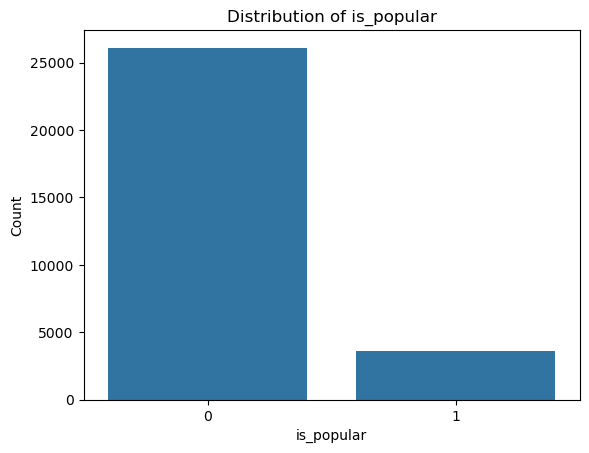

In [9]:
plt.figure()
sns.countplot(x='is_popular', data=data)
plt.title('Distribution of is_popular')
plt.xlabel('is_popular')
plt.ylabel('Count')
plt.show()

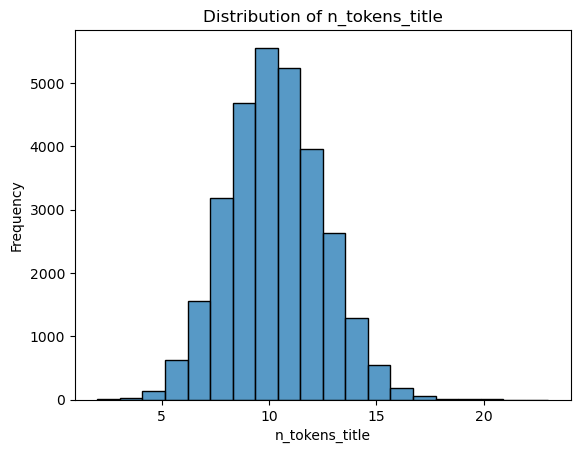

In [10]:
plt.figure()
sns.histplot(data['n_tokens_title'], bins=20)
plt.title('Distribution of n_tokens_title')
plt.xlabel('n_tokens_title')
plt.ylabel('Frequency')
plt.show()

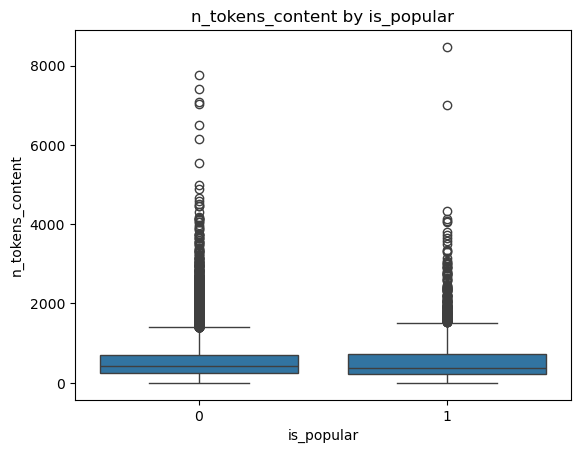

In [11]:
plt.figure()
sns.boxplot(x='is_popular', y='n_tokens_content', data=data)
plt.title('n_tokens_content by is_popular')
plt.xlabel('is_popular')
plt.ylabel('n_tokens_content')
plt.show()


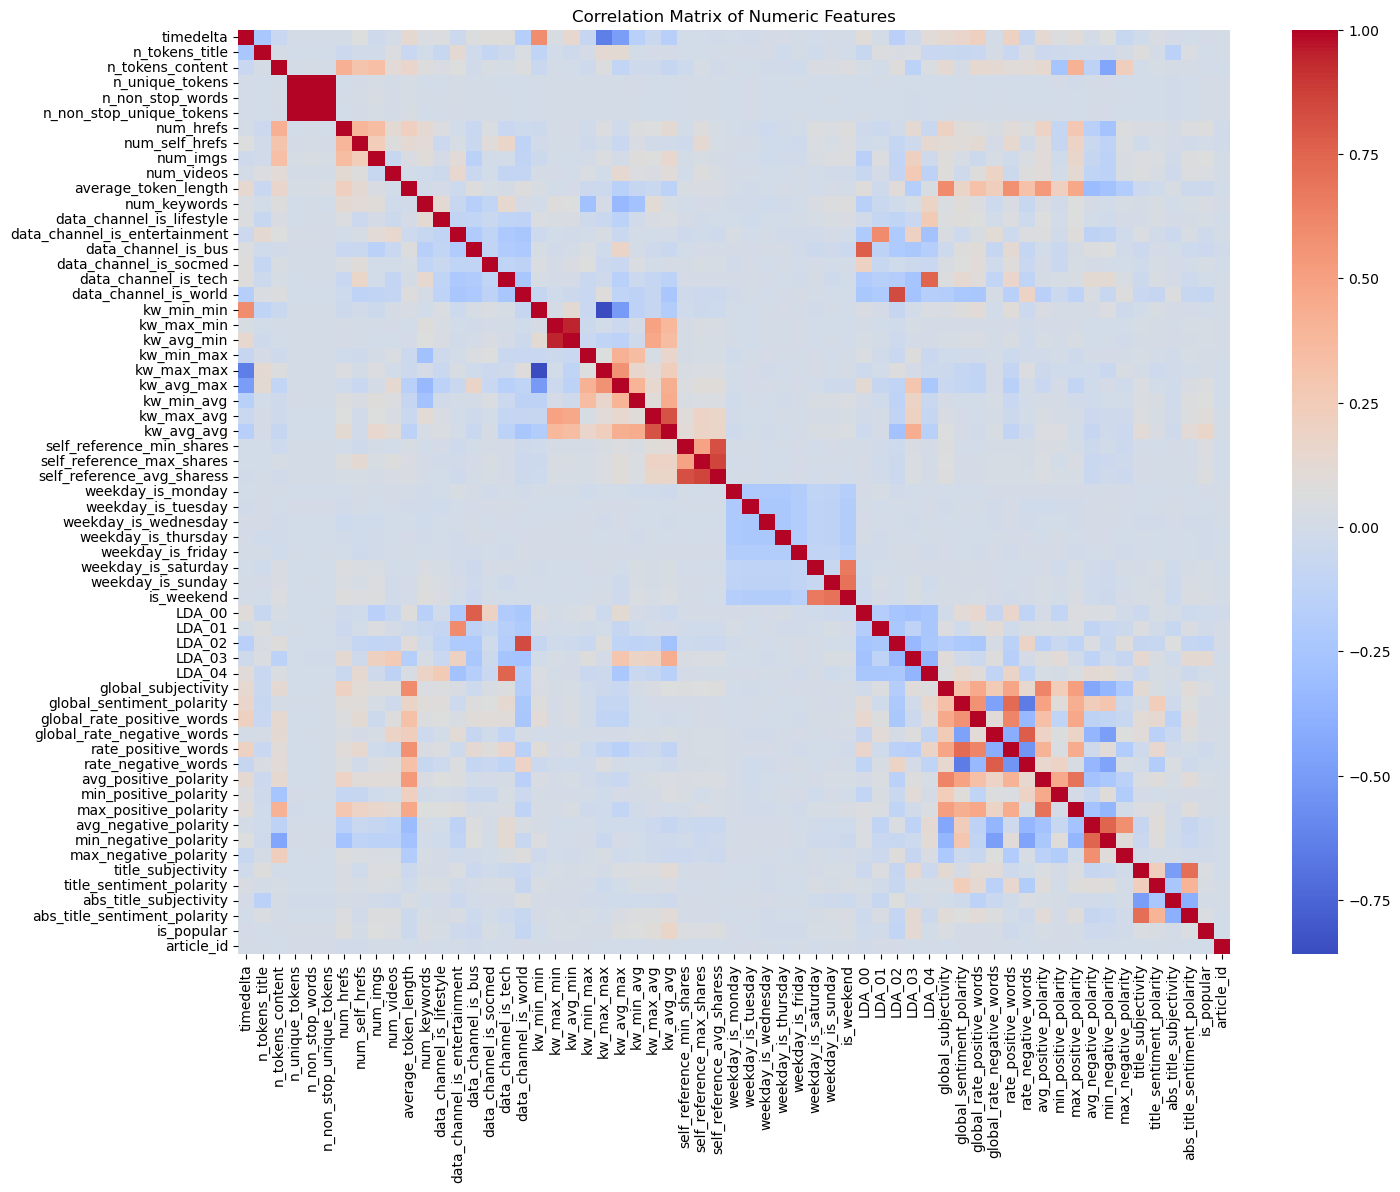

In [12]:
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
corr = data[numeric_cols].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [13]:
corr_matrix = data.corr()

is_pop_corr = corr_matrix['is_popular'].sort_values(ascending=False)
is_pop_corr

is_popular               1.000000
kw_avg_avg               0.168377
LDA_03                   0.127754
kw_max_avg               0.089116
num_hrefs                0.072335
                           ...   
avg_negative_polarity   -0.037027
average_token_length    -0.043935
data_channel_is_bus     -0.048029
data_channel_is_world   -0.082891
LDA_02                  -0.098639
Name: is_popular, Length: 61, dtype: float64

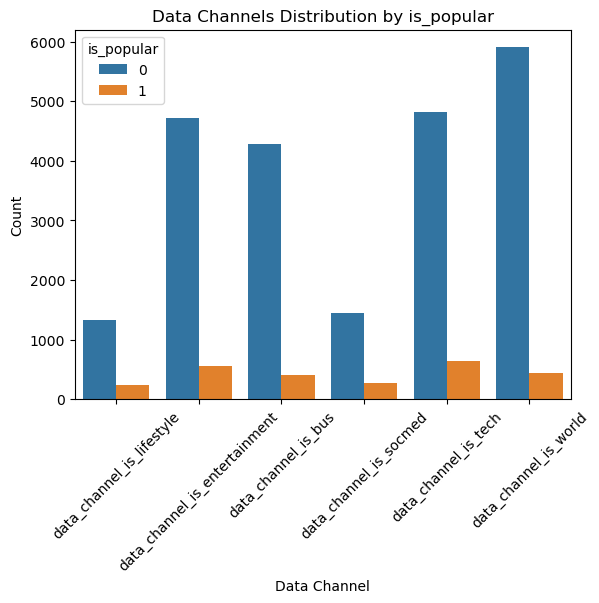

In [14]:
data_channels = ['data_channel_is_lifestyle', 'data_channel_is_entertainment',
                 'data_channel_is_bus', 'data_channel_is_socmed',
                 'data_channel_is_tech', 'data_channel_is_world']
# Melt the dataframe to plot counts per channel split by is_popular
df_channels = data.melt(id_vars=['is_popular'], value_vars=data_channels, 
                      var_name='data_channel', value_name='present')
# Keep only rows where the channel is active (value = 1)
df_channels = df_channels[df_channels['present'] == 1]

plt.figure()
sns.countplot(x='data_channel', hue='is_popular', data=df_channels)
plt.title('Data Channels Distribution by is_popular')
plt.xlabel('Data Channel')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

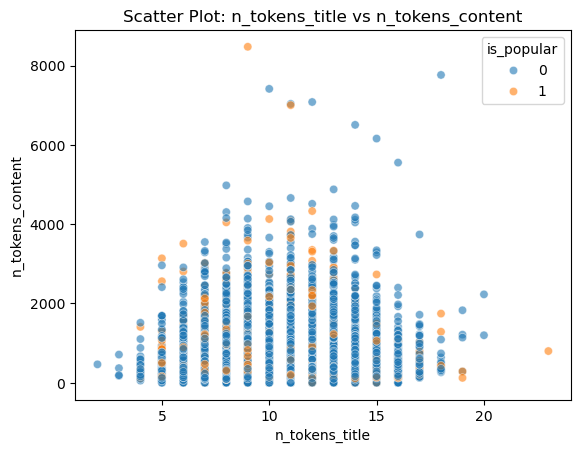

In [15]:
plt.figure()
sns.scatterplot(x='n_tokens_title', y='n_tokens_content', hue='is_popular', data=data, alpha=0.6)
plt.title('Scatter Plot: n_tokens_title vs n_tokens_content')
plt.xlabel('n_tokens_title')
plt.ylabel('n_tokens_content')
plt.show()


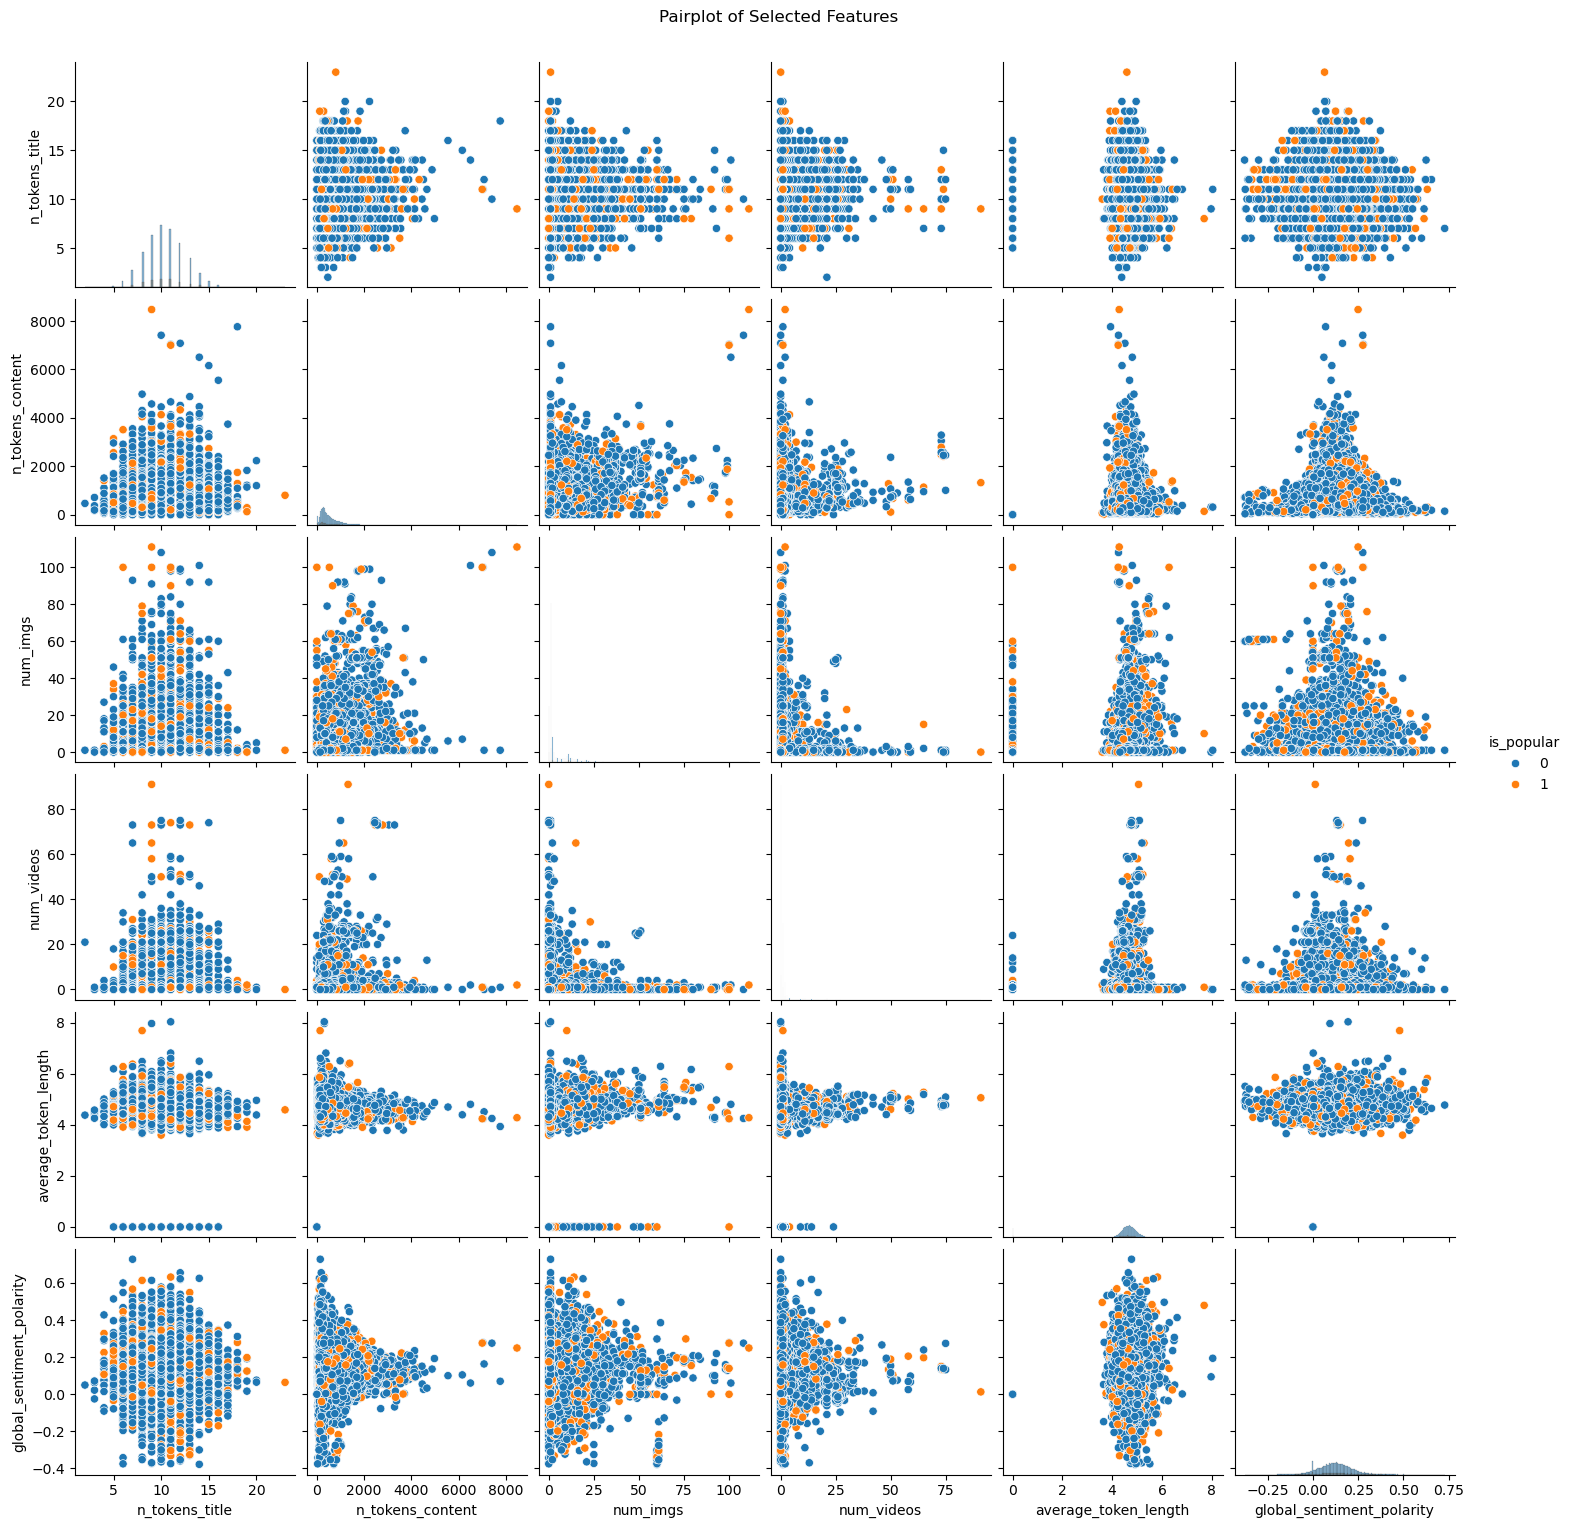

In [16]:
selected_features = ['n_tokens_title', 'n_tokens_content', 'num_imgs', 
                     'num_videos', 'average_token_length', 'global_sentiment_polarity', 
                     'is_popular']
sns.pairplot(data[selected_features], hue='is_popular', diag_kind='hist')
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()

To gain an initial understanding of the dataset, some visualizations were done to explore feature distributions, correlations, and their relationships with the target variable is_popular. The correlation heatmap shows strong positive correlations among groups of related variables, such as keyword-based metrics (kw_min_min, kw_avg_avg, etc.) and sentiment-based features (rate_positive_words, avg_positive_polarity, etc.), suggesting multicollinearity in parts of the dataset. But, most variables show weak or no linear correlation with the target, indicating that article popularity is likely influenced by complex, non-linear interactions rather than by any single feature. Some differences emerged between channels—for instance, “tech” and “entertainment” had a relatively higher proportion of popular articles compared to “lifestyle” or “socmed”—suggesting that the content category may be a moderately informative predictor. The pairplot of selected numeric features (n_tokens_title, n_tokens_content, num_imgs, num_videos, average_token_length, and global_sentiment_polarity) offered further insights: while no strong separation was observed between popular and non-popular articles, there were slight tendencies for popular articles to have more images or videos and a broader range in sentiment scores. Overall, the visual exploration highlights the complexity of the prediction task, with no dominant linear predictors, and supports the use of models capable of capturing subtle feature interactions.

# Prediction
## Liniar models

In [17]:
y = data['is_popular']
X = data.drop(columns=['is_popular', 'article_id'])
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                              random_state=prng, stratify=y)


In [18]:
features_model1 = ['kw_avg_avg', 'LDA_03', 'kw_max_avg', 'LDA_02', 'data_channel_is_world']
features_model2 = features_model1 + ['average_token_length', 'num_imgs', 'num_videos',
                                     'kw_min_avg', 
                                     'data_channel_is_entertainment', 'data_channel_is_bus', 
                                     'data_channel_is_socmed', 'self_reference_avg_sharess', 
                                     'num_hrefs']

features_model3 = [col for col in X.columns]

print("Features used in Model 1:", features_model1)
print("Features used in Model 2:", features_model2)
print("Features used in Model 3:", features_model3)

Features used in Model 1: ['kw_avg_avg', 'LDA_03', 'kw_max_avg', 'LDA_02', 'data_channel_is_world']
Features used in Model 2: ['kw_avg_avg', 'LDA_03', 'kw_max_avg', 'LDA_02', 'data_channel_is_world', 'average_token_length', 'num_imgs', 'num_videos', 'kw_min_avg', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'self_reference_avg_sharess', 'num_hrefs']
Features used in Model 3: ['timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_share

In [19]:
def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model = LogisticRegression(max_iter=1000, solver='liblinear')
    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict_proba(X_train_scaled)[:, 1]
    y_test_pred = model.predict_proba(X_test_scaled)[:, 1]
    train_auc = roc_auc_score(y_train, y_train_pred)
    test_auc = roc_auc_score(y_test, y_test_pred)
    return model, train_auc, test_auc

In [20]:
X_train_m1 = X_train_full[features_model1]
X_test_m1 = X_test_full[features_model1]
model1, train_auc1, test_auc1 = train_and_evaluate_model(X_train_m1, X_test_m1, y_train, y_test)
print("\nModel 1 (few key features):")
print("  Train ROC AUC:", train_auc1)
print("  Test ROC AUC:", test_auc1)


Model 1 (few key features):
  Train ROC AUC: 0.6638048029146193
  Test ROC AUC: 0.659647271273496


In [21]:
X_train_m2 = X_train_full[features_model2]
X_test_m2 = X_test_full[features_model2]
model2, train_auc2, test_auc2 = train_and_evaluate_model(X_train_m2, X_test_m2, y_train, y_test)
print("\nModel 2 (more features):")
print("  Train ROC AUC:", train_auc2)
print("  Test ROC AUC:", test_auc2)


Model 2 (more features):
  Train ROC AUC: 0.6857789640320578
  Test ROC AUC: 0.6802379080892816


In [22]:
X_train_m3 = X_train_full[features_model3]
X_test_m3 = X_test_full[features_model3]
model3, train_auc3, test_auc3 = train_and_evaluate_model(X_train_m3, X_test_m3, y_train, y_test)
print("\nModel 3 (all available predictive features):")
print("  Train ROC AUC:", train_auc3)
print("  Test ROC AUC:", test_auc3)


Model 3 (all available predictive features):
  Train ROC AUC: 0.6965313956134896
  Test ROC AUC: 0.6929711745653145


To evaluate the predictive potential of all models, we built three logistic regression models using increasingly rich sets of features based on their correlation with the target variable is_popular. Model 1 was constructed using the five most correlated features: kw_avg_avg, LDA_03, kw_max_avg, LDA_02, and data_channel_is_world. Model 2 extended this by adding variables including structural features like average_token_length, num_imgs, and num_videos. Finally, Model 3 utilized all available features in the dataset. The results showed a clear trend: as more features were included, the model performance improved steadily. Model 1 achieved a Train ROC AUC of 0.664 and a Test ROC AUC of 0.660, while Model 2 improved to 0.686 and 0.680, respectively. Model 3, using the full feature set, achieved the best performance with a Train ROC AUC of 0.697 and a Test ROC AUC of 0.693. These results suggest that a well-regularized linear model is capable of capturing much of the predictive signal in the data, and performs consistently without significant overfitting, even when the full feature set is included.